# Pricing Test

## Goal

Pricing optimization is, non surprisingly, another area where data science can provide huge value.
The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

## Challenge Description

Company XYZ sells a software for 39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66\% of the users have seen the old price (39), while a random sample of 33% users a higher price 59).\
The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.\
Especially he asked you the following questions:
* Should the company sell its software for 39 or 59?
* The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
* [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why

## Data

We have two tables downloadable by clicking here.\
**"test_results" - data about the test**
* **user_id **: the Id of the user. Can be joined to user_id in user_table
* **timestamp** : the date and time when the user hit for the first time company XYZ webpage. It is in user local time
* **source **: marketing channel that led to the user coming to the site. It can be: 
    * ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google ads, yahoo ads, etc. 
    * seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.
    * friend_referral : user coming from a referral link of another user
    * direct_traffic: user coming by directly typing the address of the site on the browser
* **device** : user device. Can be mobile or web
* **operative_system** : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. Other if it is none of the above
* **test**: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old/lower price)
* **price** : the price the user sees. It should match test
* **converted **: whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).


**"user_table" - Information about the user**
* **user_id** : the Id of the user. Can be joined to user_id in test_results table
* **city** : the city where the user is located. Comes from the user ip address
* **country** : in which country the city is located
* **lat** : city latitude - should match user city
* **long** : city longitude - should match user city

================================================================================================================================

In [93]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import ttest_ind

In [4]:
import os
os.chdir("F:/Data_Science/ProductSense_ABTesing_STATS/DS take home challenges/Dataset/Pricing_Test")

In [5]:
# import two datasets
test_results = pd.read_csv("test_results.csv")
user_table = pd.read_csv("user_table.csv")

## Basic Info

In [8]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [9]:
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [16]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [17]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [10]:
print("test_results: {}".format(test_results.shape))
print("user_table: {}".format(user_table.shape))

test_results: (316800, 8)
user_table: (275616, 5)


Both tables don't have missing values. \
It seems some users in the test don't have user infomation

In [26]:
# merge two tables
df_raw = pd.merge(left = test_results, right = user_table, how = "left", on = 'user_id')
# pd.merge(left = test_results, right = user_table, how = "left", left_on = 'user_id', right_on='user_id')
df_raw.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [30]:
df_raw.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

test=1 -- \\$59\
test=0(control) -- $39

In [42]:
df_raw.groupby(['test','price']).count()

user_id  timestamp  source  device  operative_system  converted  \
test price                                                                    
0    39      202517     202517  202517  202517            202517     202517   
     59         210        210     210     210               210        210   
1    39         155        155     155     155               155        155   
     59      113918     113918  113918  113918            113918     113918   

              city  country     lat    long  
test price                                   
0    39     176241   176241  176241  176241  
     59        187      187     187     187  
1    39        135      135     135     135  
     59      99053    99053   99053   99053

210 people in the control group see a higher price\
155 people are in the test sample, but they see a lower price

so we use test to differentiable the two groups, not the price

## Sanity check

**Does the control and test group split randomly?**

In [84]:
def PlotSplitSample(column):
    df = df_raw.groupby('test')[column].apply(lambda x: x.value_counts(normalize=True)).unstack()
    plt.figure(figsize = (8, 6))
    df.plot(kind = 'bar')
    plt.title(column + " --- test/control ratio")
    plt.legend(loc ='best')
    plt.show()

<Figure size 800x600 with 0 Axes>

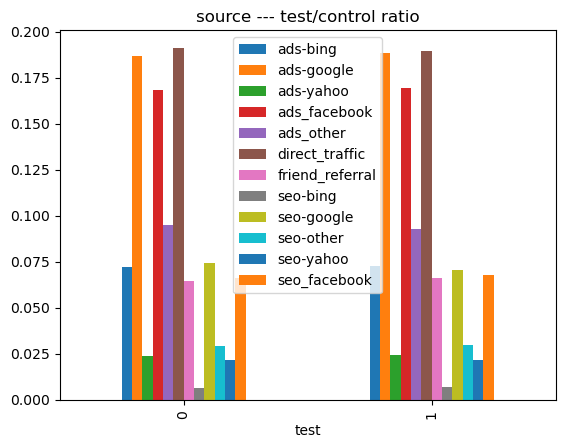

<Figure size 800x600 with 0 Axes>

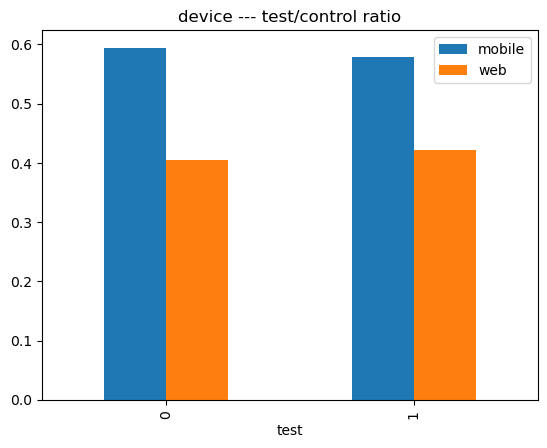

<Figure size 800x600 with 0 Axes>

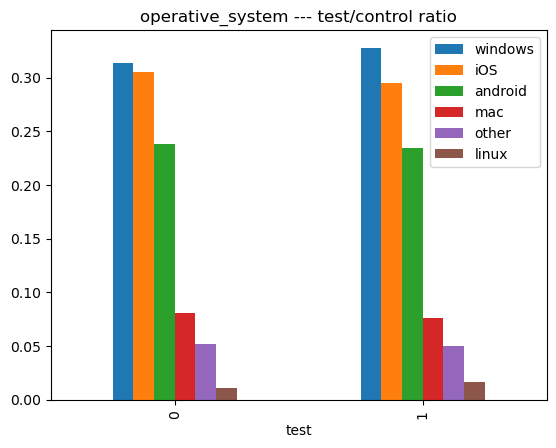

In [85]:
for i in ['source', 'device', 'operative_system']:
    PlotSplitSample(i)

Run a chi2 test to see which feature might impact the randomization of splitting groups


In [96]:
df_chi2 = df_raw[['source', 'device', 'operative_system']]
df_chi2 = pd.DataFrame(data = OrdinalEncoder().fit_transform(df_chi2),
                       columns = ['source', 'device', 'operative_system']
                      )

In [101]:
pd.DataFrame(chi2(df_chi2, df_raw['test']),
             index = ['chi2', 'p-value'],
             columns = ['source', 'device', 'operative_system'])

,source,device,operative_system
chi2,0.924742,4.436634e+01,8.308599e+01
p-value,0.336233,2.723301e-11,7.856065e-20


Device and operative system has higher chi2 value, which means they have an impact on how the groups were split.

## Question 1

In [104]:
# create a new column 'revenue'
df_raw['revenue'] = df_raw['price'] * df_raw['converted']
df_raw.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [108]:
test_group = df_raw[df_raw['test'] == 1]['revenue'].values
control_group = df_raw[df_raw['test'] == 0]['revenue'].values

H0: there is no difference in average revenue between control and treatment group\
Ha: the average revenue of treatment group is larger than control group

In [109]:
ttest_ind(test_group, control_group)

Ttest_indResult(statistic=6.1254945147248545, pvalue=9.050817331373592e-10)

t-test is a two-tail test, but we want a one-tail test. Since the p-value is much smaller than 0.05, we can reject the null hypothesis.\
However, since the control and treatment groups are not split randomly, we can not be 100% sure that \\$59 will result in high revenue.

## Question 2

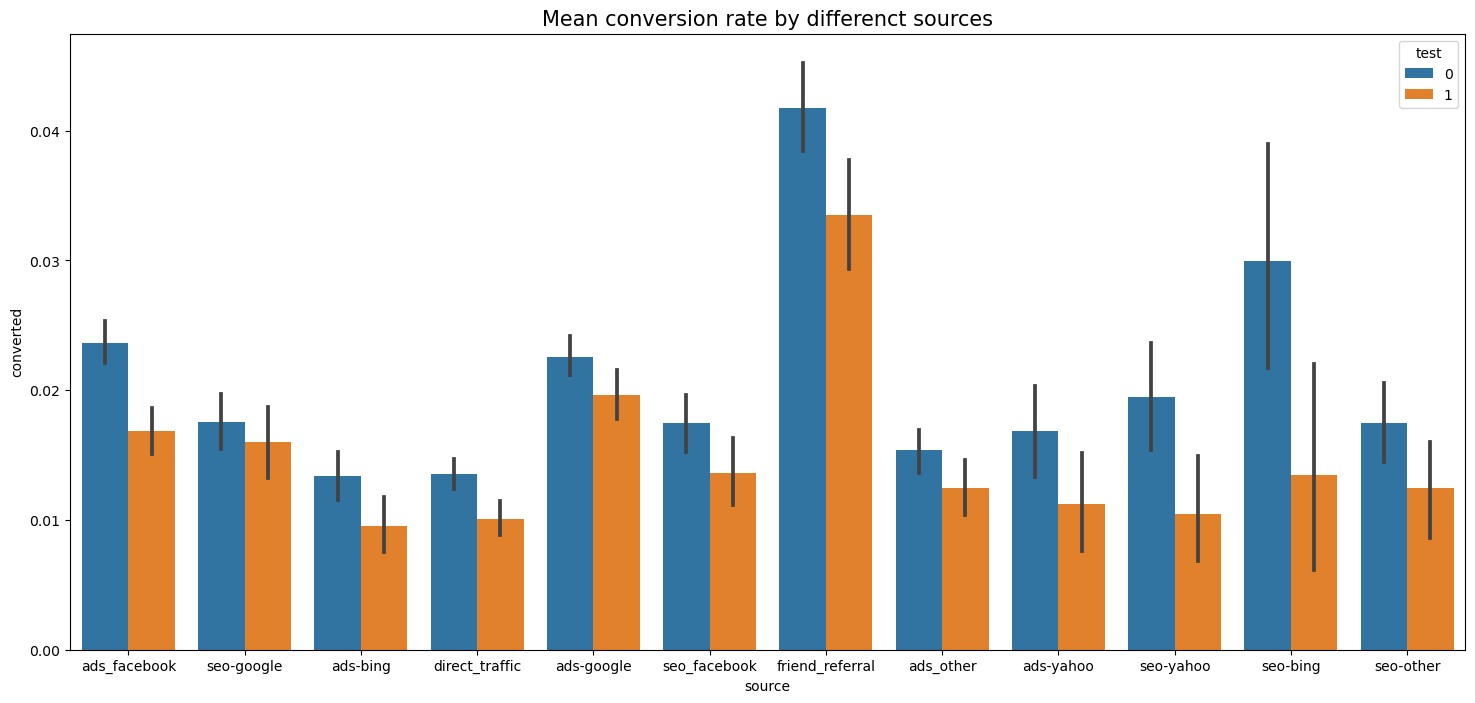

In [115]:
plt.figure(figsize = (18, 8))
sns.barplot(data = df_raw, x = 'source', y = 'converted', hue = 'test')
plt.title('Mean conversion rate by differenct sources', fontsize = 15)
plt.show()

Friend referral has the highest conversion rate. 

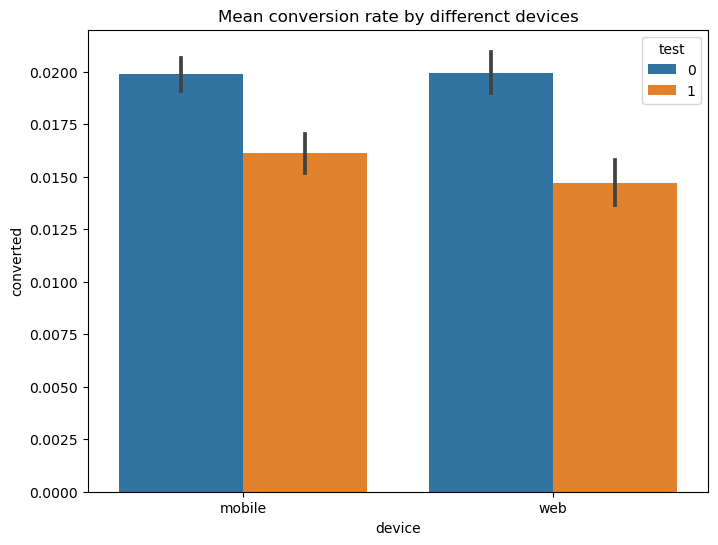

In [121]:
plt.figure(figsize = (8, 6))
sns.barplot(data = df_raw, x = 'device', y = 'converted', hue = 'test')
plt.title('Mean conversion rate by differenct devices', fontsize = 12)
plt.show()

Device doesn't seem to affect conversion rate much.

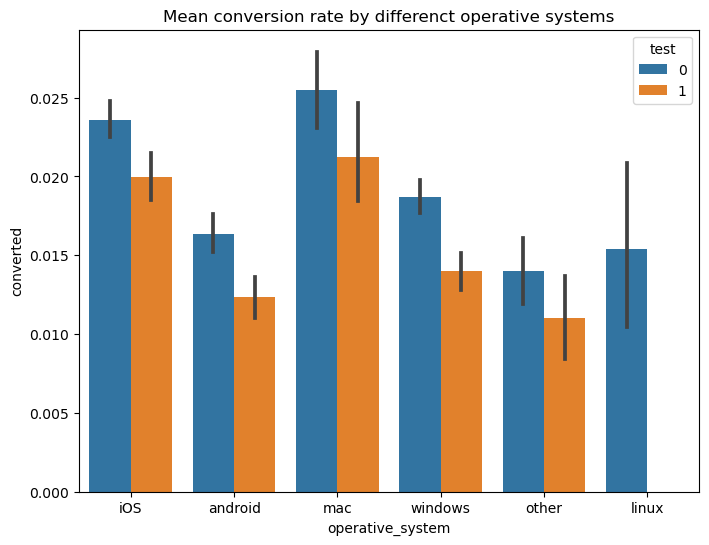

In [122]:
plt.figure(figsize = (8, 6))
sns.barplot(data = df_raw, x = 'operative_system', y = 'converted', hue = 'test')
plt.title('Mean conversion rate by differenct operative systems', fontsize = 12)
plt.show()

mac and ios have higher conversion rate than other oprative systems. \
The conversion rate of linux is the lowest, there may be adaptibility problem.

## Qustion 3

from (stasi009)[https://github.com/stasi009/TakeHomeDataChallenges/blob/master/06.PriceTest/price_test.ipynb]

friend_referral, Apple user (MAC or iOS), low price are three great positive factors which improve the conversion rate if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors\

- lauch special marketing program targeted to Apple users (MAC or iOS users)
- run some program which rewards user which can invite his/her friend to use our software


Linux users don't like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?